# Premier workflow d'identication d'un champignon
Utilisation d'un générateur d'images  
Fichiers en local sur le HDD dont les emplacements sont dans un dataset à télécharger ici: (Ca devient gros, disponible sur demande par ftp)
Utilisation d'un modèle pré-entrainé Efficientnet

Pour ce test, nous avons sélectionné les 10 genres de champignons suivants:
Paxillus, Clathrus, Geastrum, Scleroderma, Byssomerulius, Phaeolus, Agaricus, Amanita, Auricularia, Craterellus
  
Voici le lien pour télécharger les images : 

Puis dézipper le fichier au même niveau que le notebook, de sorte que le notebook et le répertoire Images soient au même niveau


In [1]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Chargement du csv contenant les chemins des images à utiliser sur le HDD
4000 liens url par classes  
Séparation jeu d'entrainement et de test à 20%

In [2]:
import pandas as pd
import pathlib

# Chargement du fichier
df = pd.read_csv ("allpath.csv")

#Création d'une nouvelle variable contenant l'arborescence sur le HDD des fichiers images
df["path"] = '/'+df["order"]+'/'+df["family"]+'/'+df["genus"]+'/'+df["species"]+'/'+'im'+df.index.astype('str')+".jpg"

# On ajoute le chemin où se trouve l'arborescence précédente (peut varier selon les personnes)
base_dir = r'C:\Users\baugn\Mush\photos\Fungi Basidiomycota Agaricomycetes'
df["path"] = base_dir+df["path"]

# On élimine les images en provenance de http:\\sweetgum.nybg.org (cf. rapport) 
df["isweetgum"]=df["identifier_y"].apply(lambda x: "sweetgum.nybg.org" in x)
df = df[df["isweetgum"]== False]


In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
0,0,0,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1,1,1,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
2,2,2,2434842541,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae,Mycena,Mycena mulawaestris,Mycena mulawaestris,AU,-37.666667,145.733333,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
3,3,3,2435361192,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Russulales,Bondarzewiaceae,Amylosporus,Amylosporus campbellii,Amylosporus campbellii,MM,NaN,NaN,False,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
4,4,4,2438837736,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Barcheria,Barcheria willisiana,Barcheria willisiana,AU,-32.176100,121.399700,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False


## On limite notre test à 10 classes et 4000 photos par classes
On augmentera encore la semaine prochaine

In [4]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Paxillus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Clathrus"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Geastrum"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Scleroderma"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Byssomerulius"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Phaeolus"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Agaricus"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Craterellus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10])

data

,Unnamed: 0,Unnamed: 0.1,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
214912,214912,228840,2444959195,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,GB,51.260840,-2.647070,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1836841,1836841,1953223,2425494665,https://svampe.databasen.org/uploads/2019-1004...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus rubicundulus,Paxillus rubicundulus i bred forstand,DK,55.771733,12.490704,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
769227,769227,804568,2447936933,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus cuprinus,Paxillus cuprinus,US,37.374952,-122.076610,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
441517,441517,462980,2832874847,https://observation.org/photos/12379336.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,"Paxillus involutus sl, incl. filamentosus, obs...",NL,52.450000,6.250000,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1895652,1895652,2019082,2303159552,https://svampe.databasen.org/uploads/2019-1002...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus ammoniavirescens,Paxillus ammoniavirescens Contu & DessÏ,DK,55.120564,11.804489,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533927,1533927,1634754,3031816270,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,US,44.018973,-122.581094,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1059000,1059000,1116308,2574190800,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,US,41.358500,-79.211350,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1779625,1779625,1891163,1847646444,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus foetidus,Craterellus foetidus,US,39.326050,-82.103250,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1106622,1106622,1166420,3032169843,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus fallax,Craterellus fallax,US,42.664148,-71.517472,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False


## Création des ensembles d'entrainement et de test

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

data.head()

,Unnamed: 0,Unnamed: 0.1,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
214912,214912,228840,2444959195,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,GB,51.260840,-2.647070,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1836841,1836841,1953223,2425494665,https://svampe.databasen.org/uploads/2019-1004...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus rubicundulus,Paxillus rubicundulus i bred forstand,DK,55.771733,12.490704,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
769227,769227,804568,2447936933,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus cuprinus,Paxillus cuprinus,US,37.374952,-122.076610,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
441517,441517,462980,2832874847,https://observation.org/photos/12379336.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,"Paxillus involutus sl, incl. filamentosus, obs...",NL,52.450000,6.250000,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False
1895652,1895652,2019082,2303159552,https://svampe.databasen.org/uploads/2019-1002...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus ammoniavirescens,Paxillus ammoniavirescens Contu & DessÏ,DK,55.120564,11.804489,True,C:\Users\baugn\Mush\photos\Fungi Basidiomycota...,False


## Test d'affichage de la première image du Data_Test 

In [6]:
from tensorflow.keras.preprocessing import image

filename = data_test.path.iloc[0]

# A conserver pour d'autres tests rapides
#img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\baugn\\Mush\\photos\\Fungi Basidiomycota Agaricomycetes/Agaricales/Agaricaceae/Agaricus/Agaricus appendiculatus/im1646494.jpg'

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [10]:
# Entrainment depuis des images données dans un dataset
batch_size = 20 
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', #"raw", #"'binary', #'sparse' ?
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))

C:\Users\baugn\anaconda3\envs\efficientgpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 17012 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 14988 validated image filenames belonging to 10 classes.
Found 3764 validated image filenames belonging to 10 classes.


C:\Users\baugn\anaconda3\envs\efficientgpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4236 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Elimination des fichiers corrompus sur le HDD
Nous avons pu constater que des fichiers corrompus faisaient planter les modèles 

In [11]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)
        
tab = validation_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)

## Création du modèle Effiecientnet pré-entrainé 

In [12]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.applications.efficientnet as efn
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(optimizer = "adam", #optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                   loss = 'sparse_categorical_crossentropy', #loss = 'binary_crossentropy', 
                   metrics = ['acc'])


## Entrainement

In [18]:
history = model.fit(train_generator, 
                         validation_data = validation_generator, 
                        steps_per_epoch=int(8000/batch_size),
                         validation_steps=int(2000/batch_size),epochs=10)

Epoch 1/10
400/400 [==============================] - 219s 547ms/step - loss: 0.9522 - acc: 0.6771 - val_loss: 0.7741 - val_acc: 0.7445
Epoch 2/10
400/400 [==============================] - 218s 545ms/step - loss: 0.8956 - acc: 0.6944 - val_loss: 0.7928 - val_acc: 0.7250
Epoch 3/10
400/400 [==============================] - 223s 556ms/step - loss: 0.8616 - acc: 0.7062 - val_loss: 0.7590 - val_acc: 0.7515
Epoch 4/10
400/400 [==============================] - 218s 545ms/step - loss: 0.8456 - acc: 0.7138 - val_loss: 0.7773 - val_acc: 0.7350
Epoch 5/10
400/400 [==============================] - 217s 543ms/step - loss: 0.8312 - acc: 0.7203 - val_loss: 0.7491 - val_acc: 0.7435
Epoch 6/10
400/400 [==============================] - 217s 541ms/step - loss: 0.8077 - acc: 0.7255 - val_loss: 0.7125 - val_acc: 0.7625
Epoch 7/10
400/400 [==============================] - 217s 542ms/step - loss: 0.7817 - acc: 0.7371 - val_loss: 0.7126 - val_acc: 0.7650
Epoch 8/10
400/400 [============================

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

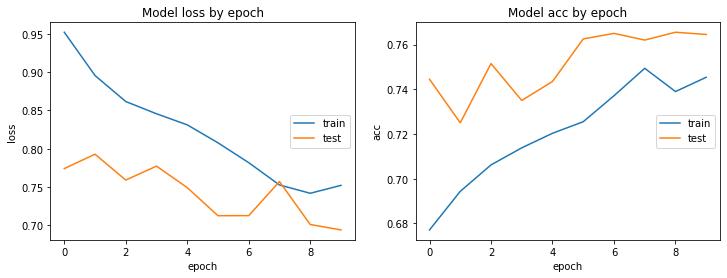

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 

On affiche les probabilités du champignon testé avec les 10 classes puis le nom de la classe choisie


In [21]:
#Récupération des classes
train_generator.get_classes(data_train, "genus")
labels = (train_generator.class_indices)
classes = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

C:\Users\baugn\Mush\photos\Fungi Basidiomycota Agaricomycetes/Phallales/Phallaceae/Clathrus/Clathrus crispatus/im965223.jpg


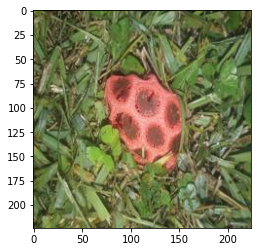

Probabilité pour les 10 classes : [[1.1236244e-12 5.8463378e-08 4.9728275e-15 7.4601349e-14 1.0000000e+00
  1.5655048e-14 6.2530567e-12 4.7595435e-12 3.6564496e-13 1.2377168e-11]]
Classe présentie : Clathrus


In [22]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

C:\Users\baugn\Mush\photos\Fungi Basidiomycota Agaricomycetes/Geastrales/Geastraceae/Geastrum/Geastrum triplex/im1135488.jpg


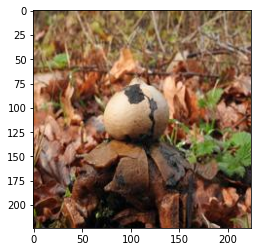

Probabilité pour les 10 classes : [[2.1097638e-05 5.6878316e-06 4.8763514e-08 1.0870903e-08 2.6677658e-06
  1.8284492e-04 9.9973613e-01 1.5644996e-08 2.6528979e-10 5.1569248e-05]]
Classe présentie : Geastrum


In [26]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

C:\Users\baugn\Mush\photos\Fungi Basidiomycota Agaricomycetes/Auriculariales/Auriculariaceae/Auricularia/Auricularia cornea/im24906.jpg


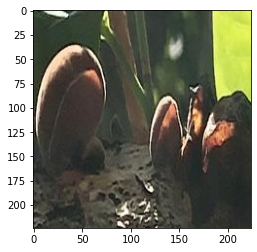

Probabilité pour les 10 classes : [[0.19354157 0.07185102 0.2763775  0.01950504 0.013833   0.16017526
  0.09686352 0.0687415  0.01995975 0.07915179]]
Classe présentie : Auricularia


In [27]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

C:\Users\baugn\Mush\photos\Fungi Basidiomycota Agaricomycetes/Polyporales/Phanerochaetaceae/Byssomerulius/Byssomerulius incarnatus/im390271.jpg


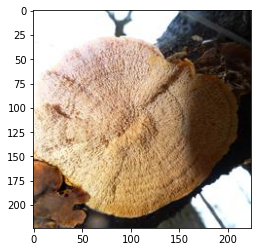

Probabilité pour les 10 classes : [[2.7367717e-02 1.4702968e-03 1.7021146e-02 5.4345036e-01 2.9092267e-05
  1.4401202e-02 5.7258243e-05 3.6046442e-01 3.5490103e-02 2.4839584e-04]]
Classe présentie : Byssomerulius


In [30]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])